<a href="https://colab.research.google.com/github/ali-07700/DSA210/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These scripts update the data by selecting only the matches of the winners and calculating their average performance in the tournaments they won. They create new metrics, remove unnecessary ones, and exclude tournaments without numerical data, such as international country tournaments like the Davis Cup. After processing, they download each year's matches along with the winners' averages. Finally, all CSV files are merged into a single file.

In [ ]:
from google.colab import files
import pandas as pd
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


This code updates every csv file to new Regulated_File there are 25 files which are updated with this code. Updating is cleaning, removing empty places, creating new metrices etc. and convert files to new csv files.


In [ ]:
print("Enter the name of the csv file (without extension):")
input_file = input()
file_path = '/content/drive/My Drive/DSA2025Spring/RawData/atp_matches_' + input_file + '.csv'
df = pd.read_csv(file_path)
filtered_file = df[~df['tourney_name'].str.contains('Davis')]
filtered_file = filtered_file[~filtered_file['tourney_name'].str.contains('Dusseldorf')]
tournaments = [i for i in filtered_file['tourney_name'].unique()]


tournament_winners = {}
for tournament in tournaments:

    tournament_matches = filtered_file[filtered_file['tourney_name'] == tournament]

    win_counts = tournament_matches['winner_name'].value_counts()

    winner = win_counts.index[0]

    tournament_winners[tournament] = winner

winners_df = pd.DataFrame(list(tournament_winners.items()), columns=['tourney_name', 'winner_name'])
merged_df = pd.merge(filtered_file, winners_df, on=['tourney_name', 'winner_name'])


average_file = merged_df

columns_to_delete = ['loser_rank_points','winner_rank_points','draw_size','tourney_id','match_num', 'tourney_date', 'winner_id', 'winner_entry', 'winner_ioc', 'loser_id', 'loser_entry', 'loser_ioc', 'round']
average_file = average_file.drop(columns=columns_to_delete)
average_file['Break_point_conversion'] = (average_file['l_bpFaced']-average_file['l_bpSaved'])/(average_file['l_bpFaced'])
average_file['Break_point_conversion'] = average_file['Break_point_conversion'].fillna(0)
average_file['Ace_per_game'] = average_file['w_ace']/average_file['w_SvGms']
average_file['Ace_per_game'] = average_file['Ace_per_game'].fillna(0)
average_file['Break_point_save_percentage'] = (average_file['w_bpSaved'])/(average_file['w_bpFaced'])
average_file['Break_point_save_percentage'] = average_file['Break_point_save_percentage'].fillna(0)
average_file['Serve_point_won_percentage'] = (average_file['w_1stWon'] + average_file['w_2ndWon'])/average_file['w_svpt']
average_file['Serve_point_won_percentage'] = average_file['Serve_point_won_percentage'].fillna(0)
average_file['Return_point_won_percentage'] = (average_file['l_svpt'] -average_file['l_1stWon'] - average_file['l_2ndWon'])/average_file['l_svpt']
average_file['Return_point_won_percentage'] = average_file['Return_point_won_percentage'].fillna(0)
tournaments = average_file['tourney_name'].unique()

# Initialize an empty list to store average match data
average_matches = []

# Columns to average (numeric columns only)
numeric_columns = average_file.select_dtypes(include=['number']).columns

# Columns to retain (categorical or non-numeric columns)
retain_columns = ['winner_name', 'surface', 'tourney_level']

# Loop through each tournament and calculate the average match
for tournament in tournaments:
    # Filter matches for the current tournament
    tournament_matches = average_file[average_file['tourney_name'] == tournament]

    # Calculate the average for numeric columns
    average_match = tournament_matches[numeric_columns].mean().to_dict()

    # Retain the most common value for categorical columns
    for column in retain_columns:
        if column == 'winner_name':
            # Retain the most frequent winner in the tournament
            average_match[column] = tournament_matches[column].mode()[0]
        else:
            # Retain the most common value for other categorical columns
            average_match[column] = tournament_matches[column].mode()[0]

    # Add the tournament name to the average match data
    average_match['tourney_name'] = tournament
    average_match['Year'] = input_file

    # Append the average match data to the list
    average_matches.append(average_match)

# Create a new DataFrame from the list of average matches
average_matches_df = pd.DataFrame(average_matches)

desired_columns = ['tourney_name', 'tourney_level', 'surface', 'winner_name', 'minutes', 'winner_rank', 'loser_rank', 'Serve_point_won_percentage', 'Ace_per_game', 'Break_point_save_percentage', 'Return_point_won_percentage', 'Break_point_conversion','Year']
new_df = average_matches_df[desired_columns]
new_df = new_df[new_df['Serve_point_won_percentage']!=0]
new_df.to_csv('RegulatedFile'+input_file+'.csv', index=False)
files.download('RegulatedFile'+input_file+'.csv')

Enter the name of the csv file (without extension):
2024


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Combining every regulated file to the one file.

In [ ]:
csv_files = ['RegulatedFile2000.csv','RegulatedFile2001.csv','RegulatedFile2002.csv','RegulatedFile2003.csv','RegulatedFile2004.csv','RegulatedFile2005.csv'
,'RegulatedFile2006.csv','RegulatedFile2007.csv','RegulatedFile2008.csv','RegulatedFile2009.csv','RegulatedFile2010.csv','RegulatedFile2011.csv'
,'RegulatedFile2012.csv','RegulatedFile2013.csv','RegulatedFile2014.csv','RegulatedFile2015.csv','RegulatedFile2016.csv','RegulatedFile2017.csv'
,'RegulatedFile2018.csv','RegulatedFile2019.csv','RegulatedFile2020.csv','RegulatedFile2021.csv','RegulatedFile2022.csv','RegulatedFile2023.csv'
,'RegulatedFile2024.csv']

combined_df = pd.concat([pd.read_csv(file) for file in csv_files])
combined_df = combined_df.sort_values(by='Year')
combined_df.to_csv('updatedData.csv', index=False)
files.download('updatedData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This section of the code analyzes the refined dataset, comparing key metrics across different categories, identifying trends, and examining correlations between performance indicators. It provides insights into how various factors, such as court surface and tournament level, influence player performance over time.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = "updatedData.csv"
df = pd.read_csv(file_path)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Define metrics
metrics = [
    "Serve_point_won_percentage",
    "Ace_per_game",
    "Break_point_save_percentage",
    "Return_point_won_percentage",
    "Break_point_conversion",
]


Histgorams for each metrics which will get investigated.

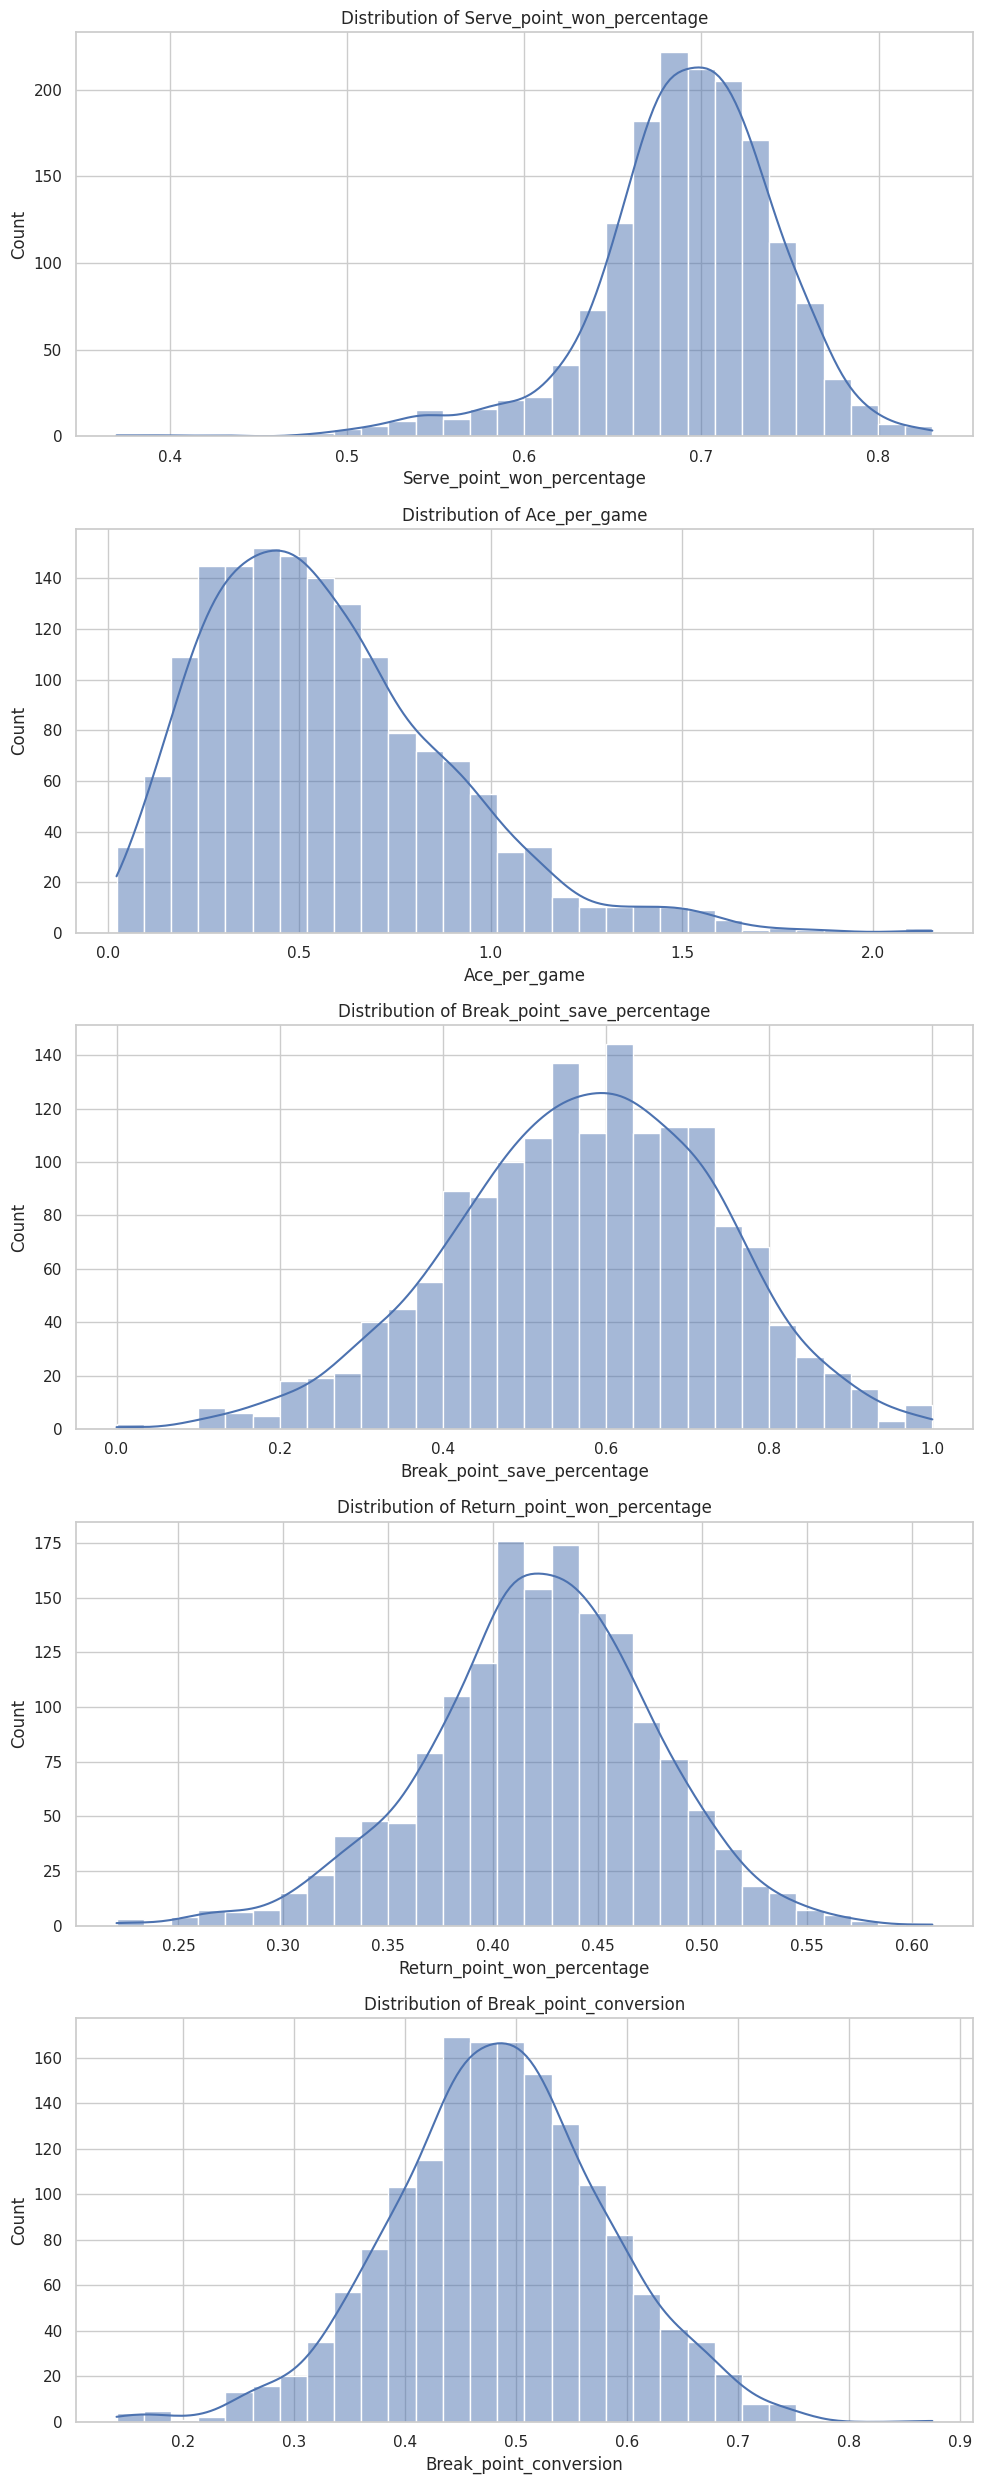

In [ ]:
# --- HISTOGRAMS ---
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 25))
for i, metric in enumerate(metrics):
    sns.histplot(df[metric], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {metric}")
plt.tight_layout()
plt.show()

Heatmap to look are there any correlation between metrices.

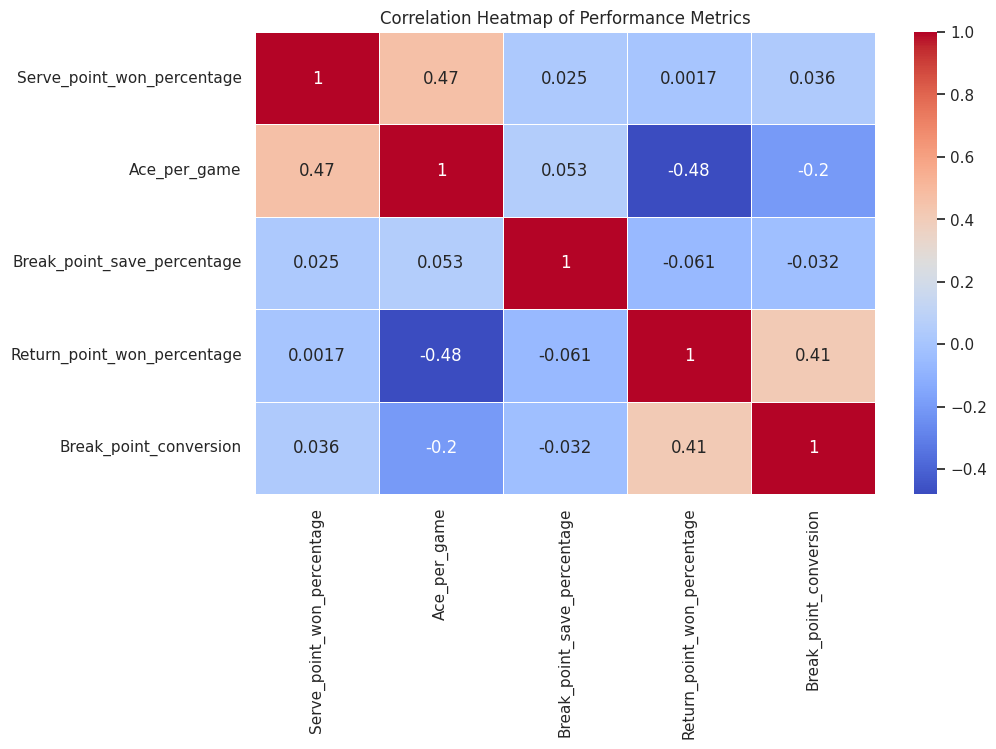

In [ ]:
# --- HEATMAP ---
plt.figure(figsize=(10, 6))
sns.heatmap(df[metrics].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Performance Metrics")
plt.show()

Linear graphs to see alteration of metrices through years in terms of surface.

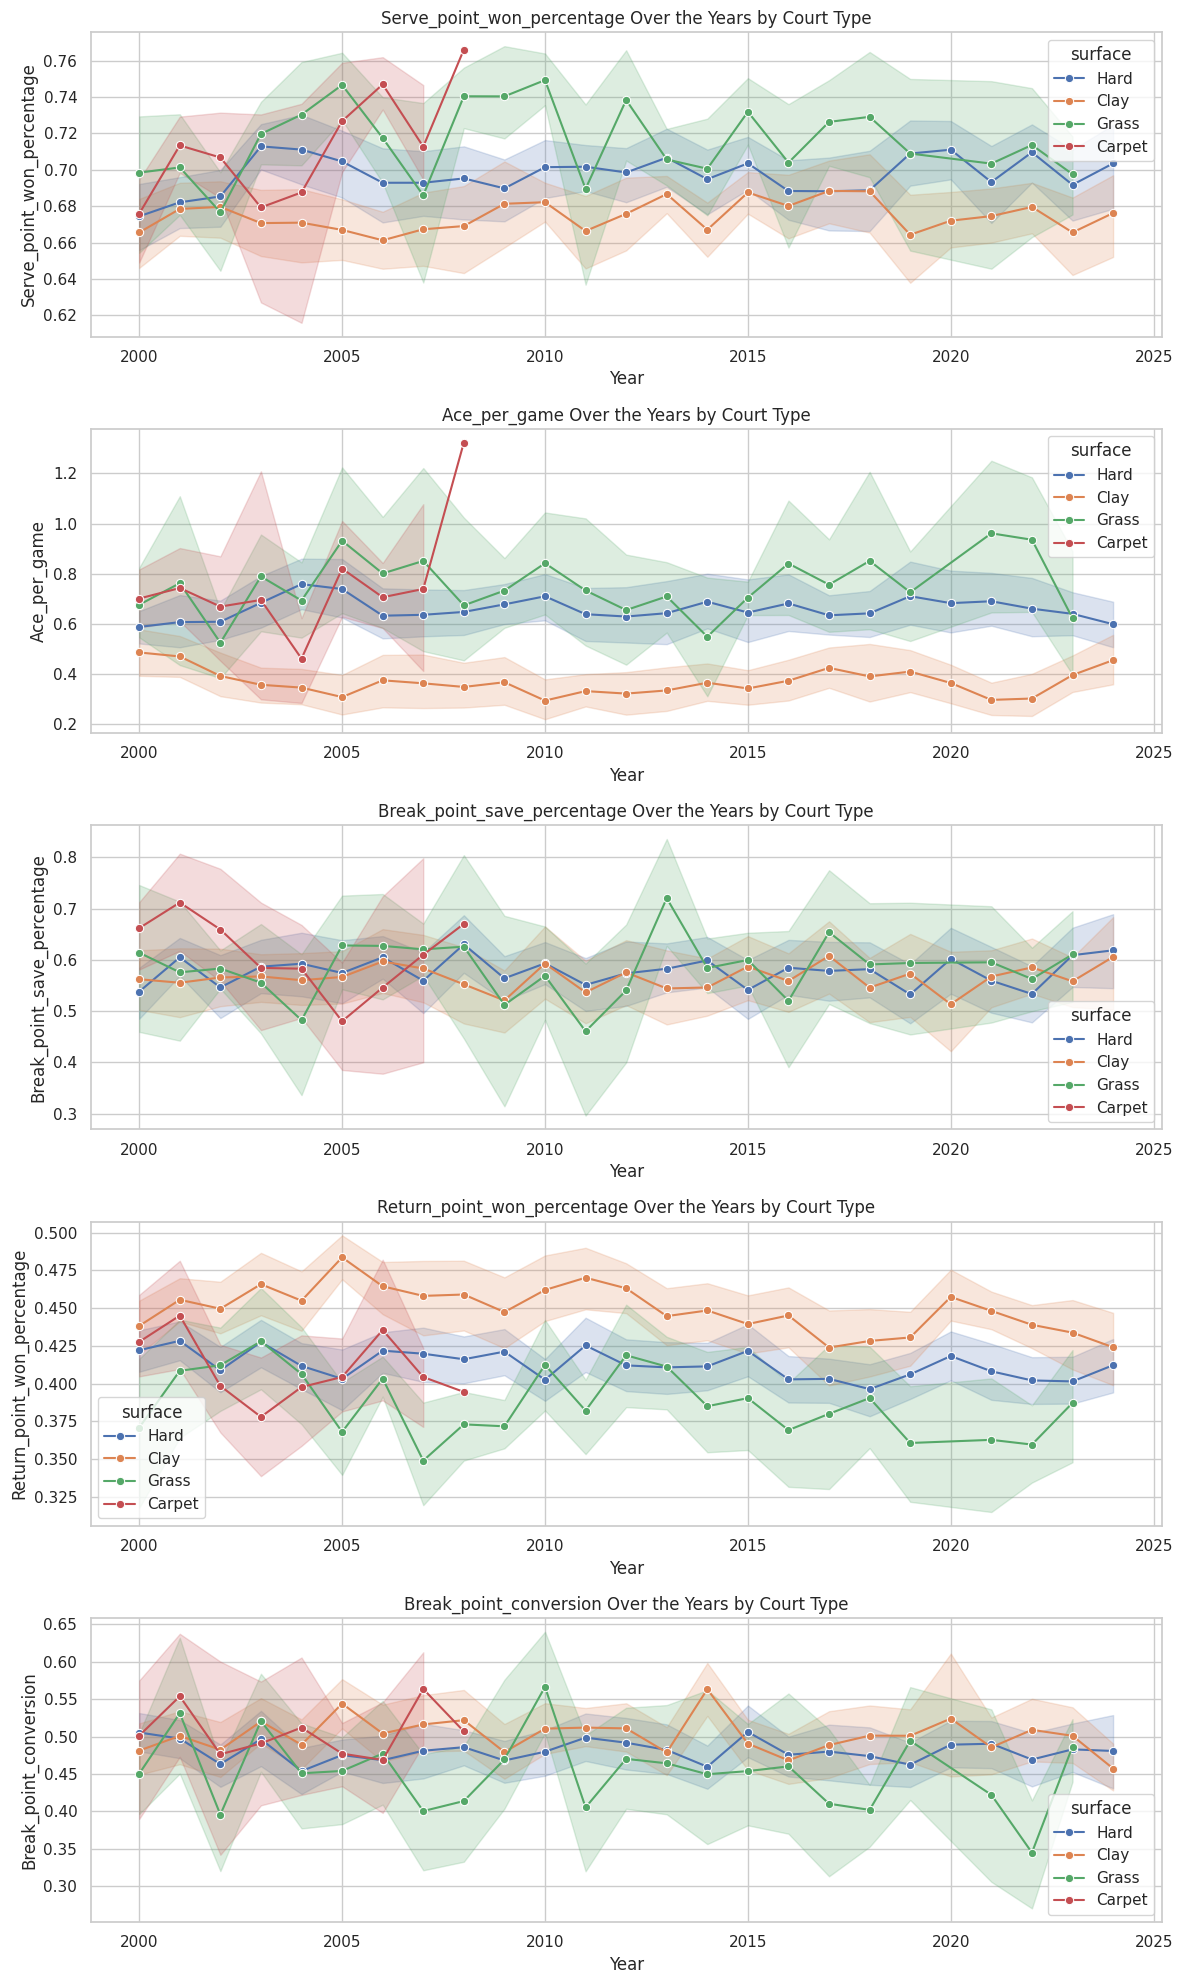

In [ ]:
# --- LINEAR GRAPHS: Yearly Trends by Surface ---
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 20))
for i, metric in enumerate(metrics):
    sns.lineplot(data=df, x="Year", y=metric, hue="surface", marker="o", ax=axes[i])
    axes[i].set_title(f"{metric} Over the Years by Court Type")
plt.tight_layout()
plt.show()

Linear graphs to see alteration of metrices through years in terms of tournament levels.

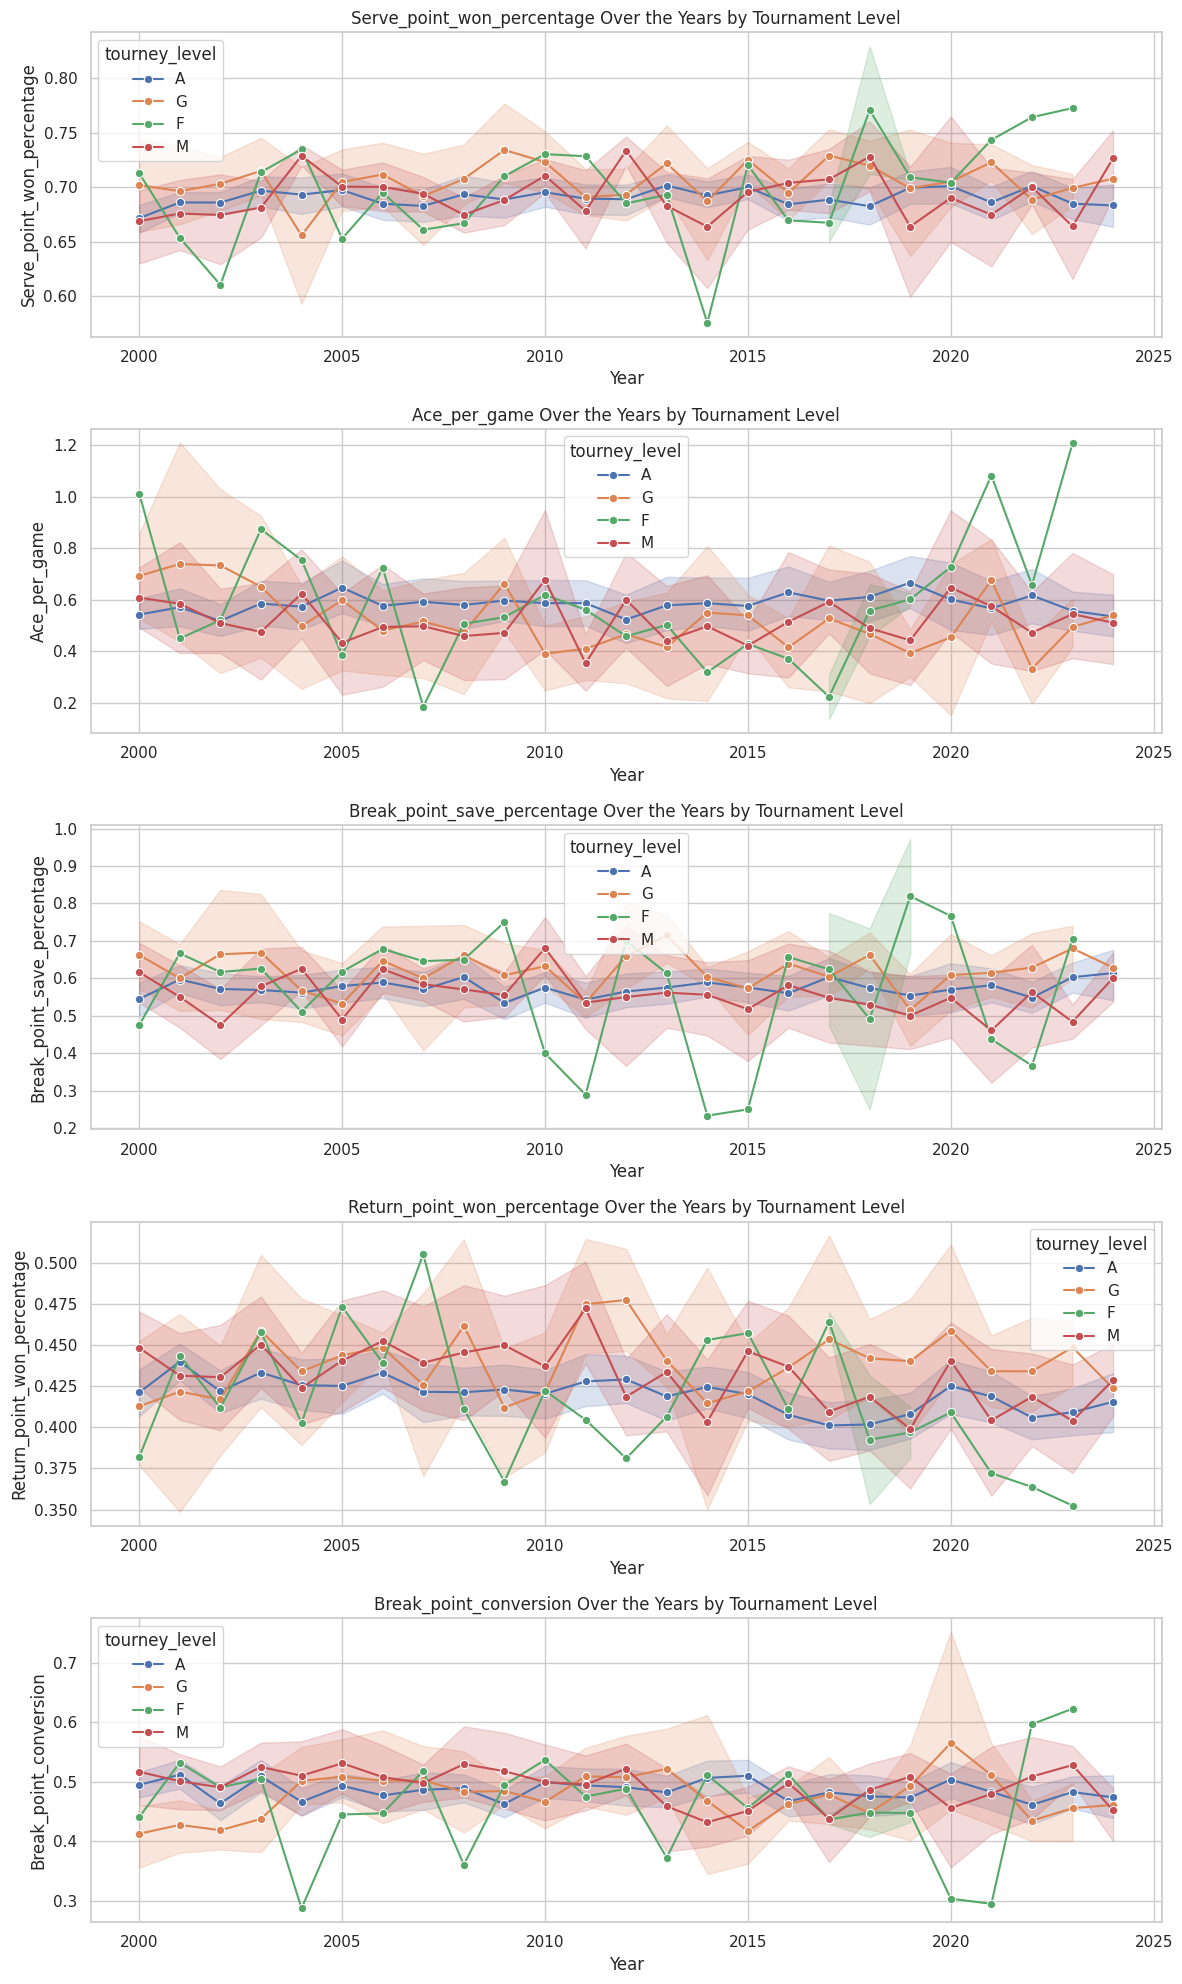

In [ ]:
# --- LINEAR GRAPHS: Yearly Trends by Tournament Level ---
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 20))
for i, metric in enumerate(metrics):
    sns.lineplot(data=df, x="Year", y=metric, hue="tourney_level", marker="o", ax=axes[i])
    axes[i].set_title(f"{metric} Over the Years by Tournament Level")
plt.tight_layout()
plt.show()

This code tracks changes in metrics over the years.

<Figure size 1200x600 with 0 Axes>

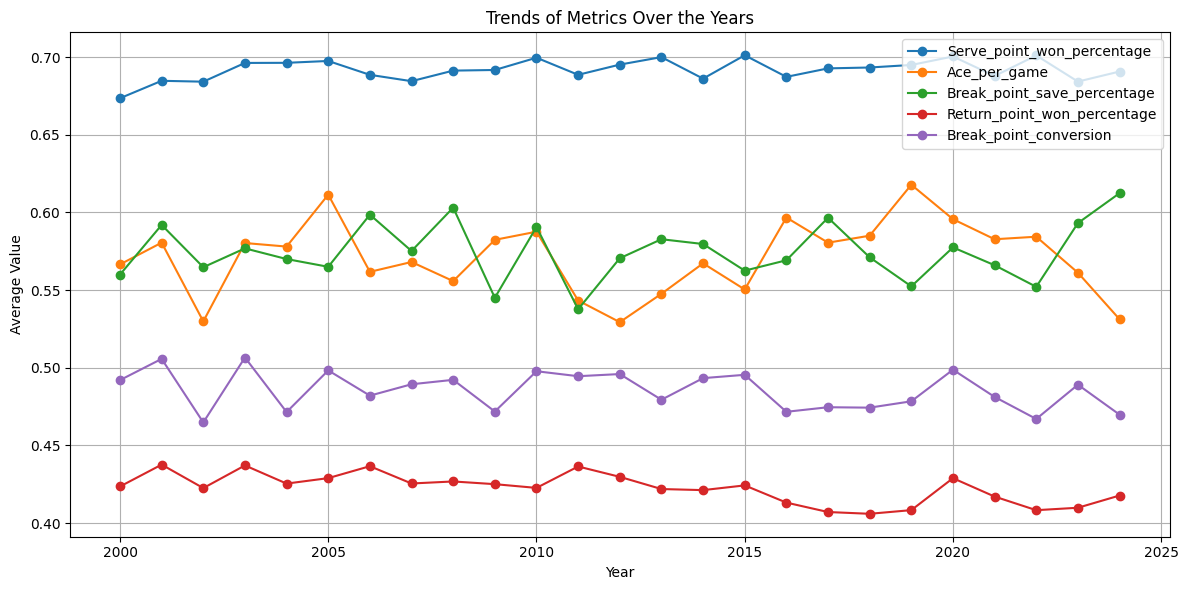

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
file_path = "updatedData.csv"  # Replace with your file path
df = pd.read_csv(file_path)
metrics = [
    "Serve_point_won_percentage",
    "Ace_per_game",
    "Break_point_save_percentage",
    "Return_point_won_percentage",
    "Break_point_conversion",
]

# Group data by year and calculate the mean for each metric
year_means = df.groupby("Year")[metrics].mean()

# Create a line plot to visualize trends over the years
plt.figure(figsize=(12, 6))
year_means.plot(kind="line", marker="o", figsize=(12, 6))
plt.title("Trends of Metrics Over the Years")
plt.ylabel("Average Value")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()

This code is for hypothesis testing for each metrics on the each surface and hypothesis testing for each metrics for each tournemant level. ANOVA is used for comparing means of ever year. Also for this research critical value p is 0.05. Code is comparing p values with critical value and displays is the result Fail to Reject H0 or Reject H0.

In [3]:
import pandas as pd
import scipy.stats as stats

# 1. READ CSV FILE
df = pd.read_csv("updatedData.csv")

# Significance level (critical value)
alpha = 0.05

# The five metrics you want to test
metrics = [
    "Serve_point_won_percentage",
    "Ace_per_game",
    "Break_point_save_percentage",
    "Return_point_won_percentage",
    "Break_point_conversion"
]

###############################################################################
# PART 1: ANOVA for each SURFACE across different YEARS
###############################################################################

surfaces = df["surface"].dropna().unique()

print("=== ANOVA by Year for each Surface ===")
for surface in surfaces:
    df_surface = df[df["surface"] == surface]

    for metric in metrics:
        years = df_surface["Year"].dropna().unique()

        groups = [
            df_surface[df_surface["Year"] == y][metric].dropna()
            for y in years
            if len(df_surface[df_surface["Year"] == y][metric].dropna()) > 0
        ]

        if len(groups) > 1:
            F_stat, p_value = stats.f_oneway(*groups)
            decision = "Reject H0" if p_value < alpha else "Fail to Reject H0"
            print(
                f"Surface: {surface}, Metric: {metric} => "
                f"F={F_stat:.4f}, p={p_value:.4f}  ({decision})"
            )
        else:
            print(
                f"Surface: {surface}, Metric: {metric} => Not enough data to perform ANOVA"
            )

print("\n")

###############################################################################
# PART 2: ANOVA for each TOURNAMENT LEVEL across different YEARS
###############################################################################

levels = df["tourney_level"].dropna().unique()

print("=== ANOVA by Year for each Tournament Level ===")
for level in levels:
    df_level = df[df["tourney_level"] == level]

    for metric in metrics:
        years = df_level["Year"].dropna().unique()

        groups = [
            df_level[df_level["Year"] == y][metric].dropna()
            for y in years
            if len(df_level[df_level["Year"] == y][metric].dropna()) > 0
        ]

        if len(groups) > 1:
            F_stat, p_value = stats.f_oneway(*groups)
            decision = "Reject H0" if p_value < alpha else "Fail to Reject H0"
            print(
                f"Tournament Level: {level}, Metric: {metric} => "
                f"F={F_stat:.4f}, p={p_value:.4f}  ({decision})"
            )
        else:
            print(
                f"Tournament Level: {level}, Metric: {metric} => Not enough data to perform ANOVA"
            )

###############################################################################
# PART 3: ANOVA by Year for each Metric (all data combined)
###############################################################################

print("\n")
print("=== ANOVA by Year (all Surfaces & Levels Combined) ===")
years_all = df["Year"].dropna().unique()

for metric in metrics:
    groups = [
        df[df["Year"] == y][metric].dropna()
        for y in years_all
        if len(df[df["Year"] == y][metric].dropna()) > 0
    ]

    if len(groups) > 1:
        F_stat, p_value = stats.f_oneway(*groups)
        decision = "Reject H0" if p_value < alpha else "Fail to Reject H0"
        print(
            f"Metric: {metric} => F={F_stat:.4f}, p={p_value:.4f}  ({decision})"
        )
    else:
        print(
            f"Metric: {metric} => Not enough data to perform ANOVA"
        )


=== ANOVA by Year for each Surface ===
Surface: Hard, Metric: Serve_point_won_percentage => F=1.1649, p=0.2660  (Fail to Reject H0)
Surface: Hard, Metric: Ace_per_game => F=0.5734, p=0.9504  (Fail to Reject H0)
Surface: Hard, Metric: Break_point_save_percentage => F=0.9049, p=0.5960  (Fail to Reject H0)
Surface: Hard, Metric: Return_point_won_percentage => F=1.2209, p=0.2135  (Fail to Reject H0)
Surface: Hard, Metric: Break_point_conversion => F=0.7228, p=0.8314  (Fail to Reject H0)
Surface: Clay, Metric: Serve_point_won_percentage => F=0.7563, p=0.7923  (Fail to Reject H0)
Surface: Clay, Metric: Ace_per_game => F=1.3168, p=0.1448  (Fail to Reject H0)
Surface: Clay, Metric: Break_point_save_percentage => F=0.4425, p=0.9908  (Fail to Reject H0)
Surface: Clay, Metric: Return_point_won_percentage => F=2.1007, p=0.0018  (Reject H0)
Surface: Clay, Metric: Break_point_conversion => F=1.4096, p=0.0948  (Fail to Reject H0)
Surface: Grass, Metric: Serve_point_won_percentage => F=1.1274, p=0.327

By surface. On clay courts RPW%(Return point percentage) produced F = 2.10, p = 0.0018, so we reject the null hypothesis that yearly means are equal; no other metric–surface pair showed evidence of change.

By tournament level.  At ATP‑500 (level “A”) events, RPW% again varied across seasons (F = 1.78, p = 0.0121). All other metric–level combinations were non‑significant.

Combined data.  When surfaces and levels are pooled the pattern persists: RPW% (F = 2.18, p = 0.0008) is the sole metric whose yearly means differ, while Serve Point Won %, Ace per Game, Break‑Point Save % and Break‑Point Conversion % remain constant.